# Libraries and Imports

In [1]:
import pandas as pd
from pandas import DataFrame
from pandas import Series
import numpy as np
import colorsys
import cv2
import matplotlib.pyplot as plt
from numpy import ndarray
import itertools
import heapq
import time 
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

# Reading the data

In [2]:
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
products = pd.read_csv('products.csv')
orders = pd.read_csv('orders.csv')
target = pd.read_csv('target.csv')
order_products__prior = pd.read_csv('order_products__prior.csv')
order_products__train_test = pd.read_csv('order_products__train_test.csv')

# Section A: Exploring the data

In [3]:
orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3346078,2134068,124107,test,7,6,9,7.0
3346079,2113602,70278,test,100,4,13,5.0
3346080,2342325,175026,test,4,4,17,11.0
3346081,3367040,179234,test,19,5,23,30.0


In [4]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [5]:
order_products__prior

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


In [6]:
order_products__train_test

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


In [7]:
target

,order_id,product_id,was_in_order
0,1187899,196.0,1
1,2757217,196.0,1
2,632715,196.0,1
3,1167274,196.0,1
4,3347074,196.0,1
...,...,...,...
2959120,3421070,4987.0,0
2959121,3421070,8230.0,0
2959122,3421070,39468.0,0
2959123,3421070,39139.0,0


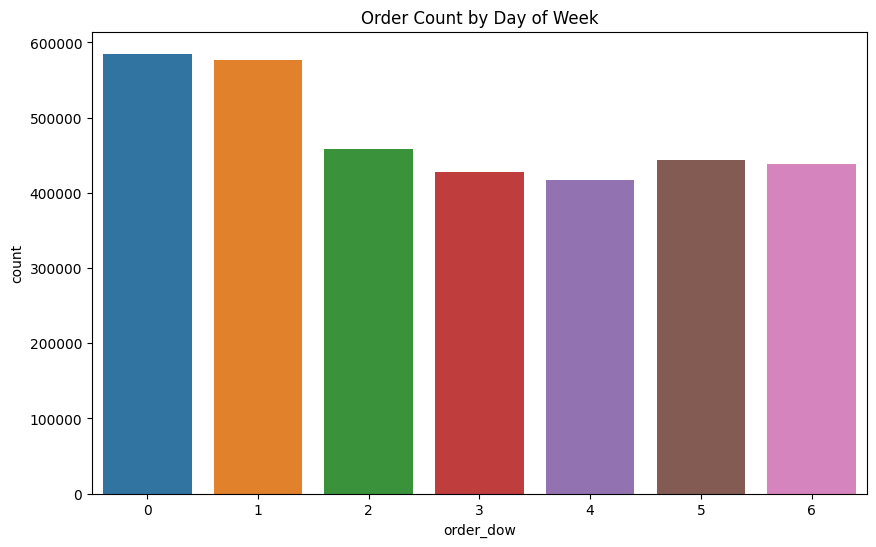

In [8]:
plt.figure(figsize=(10,6))
sns.countplot(x='order_dow', data=orders)
plt.title('Order Count by Day of Week')
plt.show()

### we can see that most people tend to make orders at the beginning of the week

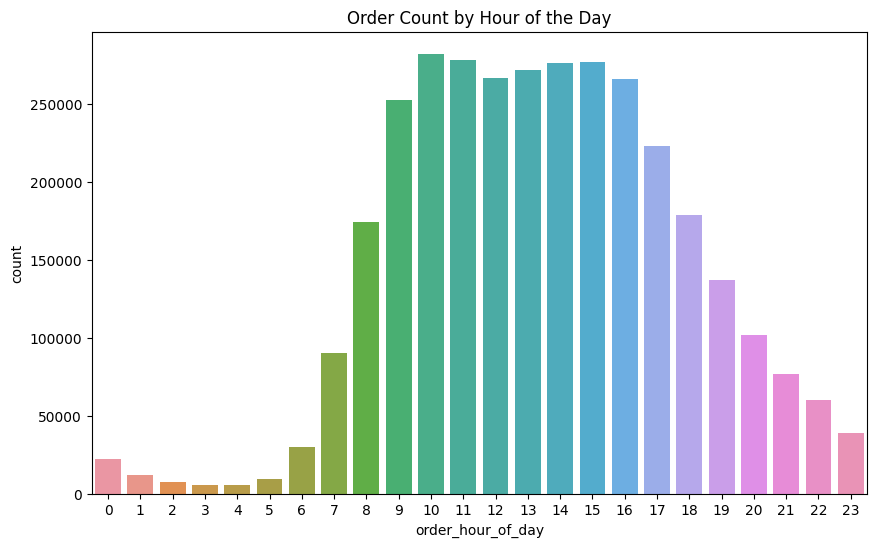

In [9]:
plt.figure(figsize=(10,6))
sns.countplot(x='order_hour_of_day', data=orders)
plt.title('Order Count by Hour of the Day')
plt.show()

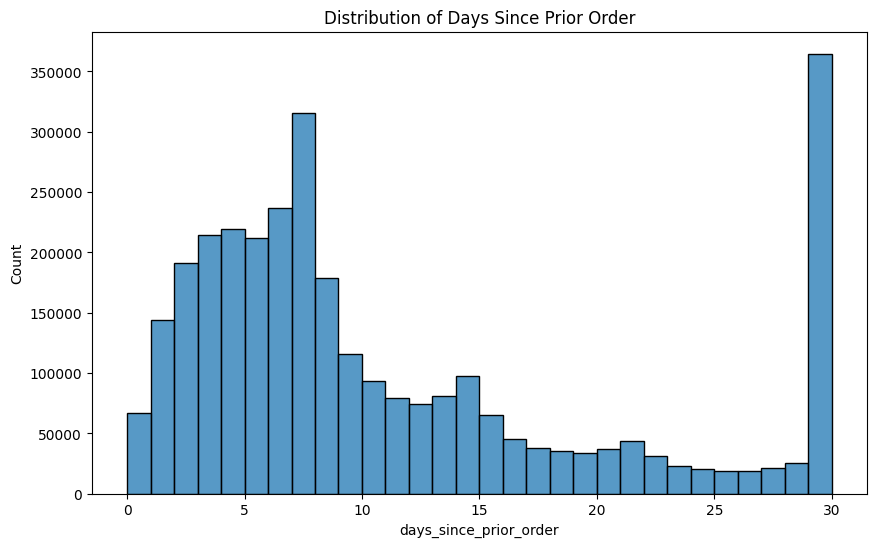

In [10]:
plt.figure(figsize=(10,6))
sns.histplot(orders['days_since_prior_order'].dropna(), bins=30, kde=False)
plt.title('Distribution of Days Since Prior Order')
plt.show()

### We can say that users tend to place and order every 7 days, 30 days.

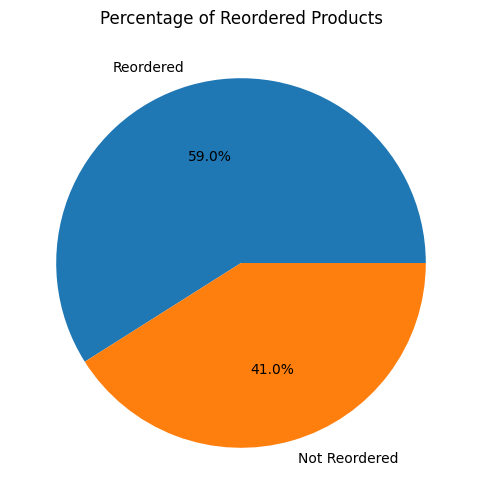

In [11]:
reorders = order_products__prior['reordered'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(reorders, labels=['Reordered', 'Not Reordered'], autopct='%1.1f%%')
plt.title('Percentage of Reordered Products')
plt.show()

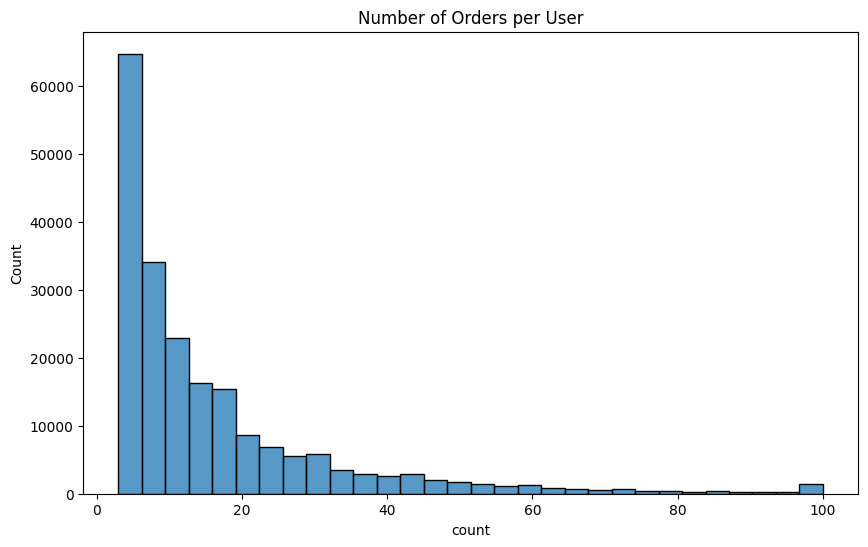

In [12]:
orders_per_user = orders['user_id'].value_counts()

plt.figure(figsize=(10,6))
sns.histplot(orders_per_user, bins=30, kde=False)
plt.title('Number of Orders per User')
plt.show()

### The tail on the right represents the regular customers, who orders frequently, while the peak on left represents the customers who orders less frequently.

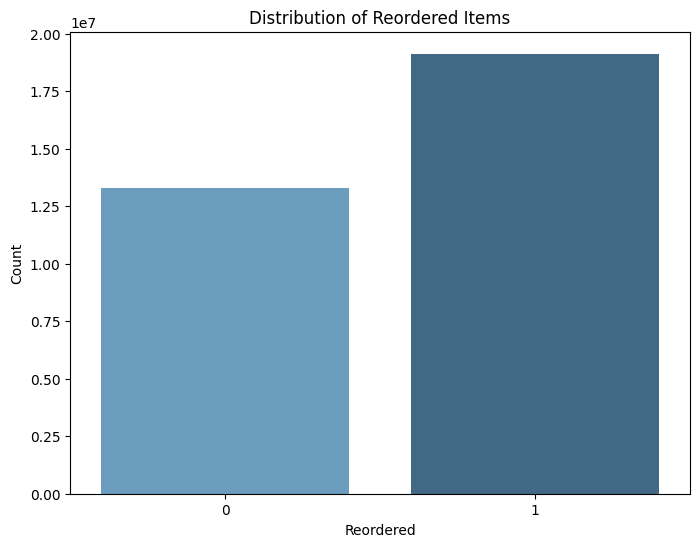

In [13]:
# Calculate the distribution of reordered values
reorder_counts = order_products__prior['reordered'].value_counts()

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=reorder_counts.index, y=reorder_counts.values, palette="Blues_d")
plt.title('Distribution of Reordered Items')
plt.xlabel('Reordered')
plt.ylabel('Count')
plt.show()

# Section B: Data Pre-Processing

### Merging the data

In [14]:
prior_orders = pd.merge(order_products__prior, orders, on='order_id', how='left')

In [15]:
prior_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 10 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   product_id              int64  
 2   add_to_cart_order       int64  
 3   reordered               int64  
 4   user_id                 int64  
 5   eval_set                object 
 6   order_number            int64  
 7   order_dow               int64  
 8   order_hour_of_day       int64  
 9   days_since_prior_order  float64
dtypes: float64(1), int64(8), object(1)
memory usage: 2.4+ GB


### Downcasting the types of data to save memory

In [16]:
prior_orders['order_id'] = pd.to_numeric(prior_orders['order_id'], downcast='integer')
prior_orders['product_id'] = pd.to_numeric(prior_orders['product_id'], downcast='integer')
prior_orders['add_to_cart_order'] = pd.to_numeric(prior_orders['add_to_cart_order'], downcast='integer')
prior_orders['reordered'] = pd.to_numeric(prior_orders['reordered'], downcast='integer')
prior_orders['user_id'] = pd.to_numeric(prior_orders['user_id'], downcast='integer')
prior_orders['order_number'] = pd.to_numeric(prior_orders['order_number'], downcast='integer')
prior_orders['order_dow'] = pd.to_numeric(prior_orders['order_dow'], downcast='integer')
prior_orders['order_hour_of_day'] = pd.to_numeric(prior_orders['order_hour_of_day'], downcast='integer')
prior_orders['days_since_prior_order'] = pd.to_numeric(prior_orders['days_since_prior_order'], downcast='float')

#### After downcasting:

In [17]:
prior_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 10 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int32  
 1   product_id              int32  
 2   add_to_cart_order       int16  
 3   reordered               int8   
 4   user_id                 int32  
 5   eval_set                object 
 6   order_number            int8   
 7   order_dow               int8   
 8   order_hour_of_day       int8   
 9   days_since_prior_order  float32
dtypes: float32(1), int16(1), int32(3), int8(4), object(1)
memory usage: 928.0+ MB


### Checking and dealing with missing values

In [18]:
prior_orders.isnull().sum()

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
dtype: int64

 Imputation: only days_since_prior_order has missing values, we will fill them with -1, which means that the order was made for the first time, 0 means that the order was made in the same after the previous one.

In [19]:
# Filling missing values in days_since_prior_order with -1
prior_orders['days_since_prior_order'].fillna(-1, inplace=True)

In [20]:
print(prior_orders.isnull().sum()/len(prior_orders))

order_id                  0.0
product_id                0.0
add_to_cart_order         0.0
reordered                 0.0
user_id                   0.0
eval_set                  0.0
order_number              0.0
order_dow                 0.0
order_hour_of_day         0.0
days_since_prior_order    0.0
dtype: float64


## Featrue Engineering

We want to create features that describes:
1. each user's behaviour.
2. each product.
3. each user's behaviour towards the products.

In [21]:
# creating dataframe for the user's features.
userData = prior_orders[['user_id']].drop_duplicates()

# creating dataframe for the product's features.
prodData = prior_orders[['product_id']].drop_duplicates()

# creating dataframe for the user's behaviour towards the products.
prodUserData = prior_orders[['user_id', 'product_id']].drop_duplicates()

### Creating requested features: 

Weekday Purchase Probability

In [22]:
# Creating a new feature: probability of a product being ordered on a specific day of the week
total_orders = prior_orders.groupby('product_id')['order_id'].count()
day_of_week_orders = prior_orders.groupby(['product_id', 'order_dow'])['order_id'].count()
weekday_purchase_prob = day_of_week_orders / total_orders
prodData['probability'] = weekday_purchase_prob.reset_index(name='weekday_purchase_prob')['weekday_purchase_prob']
merged_prior = prior_orders.copy()

Product Purchase Frequency

In [23]:
# Creating a new feature: previous purchases of a product by a user
prodUserData['previous_purchases'] = merged_prior.groupby(['user_id', 'product_id'])['order_id'].transform('count')

Days Since Last Order

In [24]:
# Creating a new feature: days since last order
merged_prior = merged_prior.sort_values(by=['user_id', 'product_id', 'order_number'])
merged_prior['order_gap'] = merged_prior.groupby(['user_id', 'product_id'])['order_number'].diff()
merged_prior['days_since_last_order'] = merged_prior.groupby(['user_id', 'product_id'])['days_since_prior_order'].cumsum()
prodUserData['days_since_last_order'] = merged_prior['days_since_last_order'] - merged_prior['days_since_prior_order']
merged_prior = merged_prior.drop(['order_gap'], axis=1)

### Creating another 7 features:

In [25]:
# 1. User's total orders
userData['total_orders'] = merged_prior.groupby('user_id')['order_number'].transform('max')

# 2. Average basket size
userData['avg_basket_size'] = merged_prior.groupby('user_id')['product_id'].transform('count') / userData['total_orders']

# 3. Average reorder ratio
userData['avg_reorder_ratio'] = merged_prior.groupby('user_id')['reordered'].transform('mean')

# 4. Product purchase frequency
prodUserData['product_purchase_frequency'] = merged_prior.groupby('product_id')['user_id'].transform('count') / userData['user_id'].nunique()


# 5. Order_hour_of_day_period (Assuming 0-6 is night, 7-12 is morning, 13-18 is afternoon and 19-23 is evening)
bins = [0, 6, 12, 18, 23]
#Night=1, Morning=2, Afternoon=3, Evening=4
labels = ['0', '1', '2', '3']
userData['order_hour_of_day_period'] = pd.cut(merged_prior['order_hour_of_day'], bins=bins, labels=labels, include_lowest=True)

#prod ratio
prodData['prod_ratio'] = merged_prior.groupby('product_id')['order_id'].transform('count') / merged_prior['order_id']

#average days between orders
userData['average_days_between_orders'] = merged_prior.groupby('user_id')['days_since_prior_order'].transform('mean')

In [26]:
userData

,user_id,total_orders,avg_basket_size,avg_reorder_ratio,order_hour_of_day_period,average_days_between_orders
0,202279,8,11.250000,0.477778,1,19.322222
9,205970,25,12.920000,0.588235,2,9.337461
17,178520,56,16.482143,0.884074,1,6.631636
30,156122,52,18.596154,0.840745,2,6.834540
56,22352,8,11.375000,0.087912,1,22.857143
...,...,...,...,...,...,...
30480369,106087,3,8.333333,0.120000,2,1.800000
30557497,9295,3,3.333333,0.400000,3,20.400000
30756656,106586,3,5.000000,0.066667,1,15.533334
30944334,181902,3,20.333333,0.262295,3,3.901639


In [27]:
prodData

,product_id,probability,prod_ratio
0,33120,0.108531,9.700000e+03
1,28985,0.215983,3.372450e+04
2,9327,0.146328,3.149500e+03
3,45918,0.141469,3.720000e+02
4,30035,0.159287,2.845000e+02
...,...,...,...
30670613,7726,NaN,6.182264e-07
30954037,43492,NaN,6.125389e-07
30974732,33097,NaN,3.060724e-07
32168896,38977,NaN,2.947113e-07


In [28]:
prodUserData

,user_id,product_id,previous_purchases,days_since_last_order,product_purchase_frequency
0,202279,33120,5,-1.0,0.094079
1,202279,28985,5,19.0,0.327090
2,202279,9327,1,0.0,0.030547
3,202279,45918,5,20.0,0.003608
4,202279,30035,3,0.0,0.002759
...,...,...,...,...,...
32434480,25247,45309,1,0.0,0.005941
32434481,25247,21162,1,0.0,0.026977
32434483,25247,35211,1,0.0,0.000548
32434485,25247,11352,1,0.0,0.034281


### Transformation -  Normalizing, and Splitting the new Features to numerical and catagorical.

In [29]:
def normalize(df,k):
    for col in df.columns[k:]:
        if len(df[col].unique()) <= 25 or col.endswith('dow') or col.endswith('hour') or col.endswith('period') or col.endswith('preference'): 
            df[col] = df[col].astype('category')
        else:
            df[col] = df[col].astype('float32')

In [30]:
#call normalize with userData, prodData, prodUserData
normalize(userData, 1)
normalize(prodData, 1)
normalize(prodUserData, 2)

    Normalized

# Section C: Future Order Prediction

### Creating Train and Test Dataframes

In [31]:
#merge orders with target
final = pd.merge(target, orders, on='order_id', how='left')

In [32]:
final

,order_id,product_id,was_in_order,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1187899,196.0,1,1,test,11,4,8,14.0
1,2757217,196.0,1,67,test,25,0,11,5.0
2,632715,196.0,1,676,train,12,0,13,26.0
3,1167274,196.0,1,760,test,5,4,10,8.0
4,3347074,196.0,1,804,train,16,3,21,5.0
...,...,...,...,...,...,...,...,...,...
2959120,3421070,4987.0,0,139822,test,15,6,10,8.0
2959121,3421070,8230.0,0,139822,test,15,6,10,8.0
2959122,3421070,39468.0,0,139822,test,15,6,10,8.0
2959123,3421070,39139.0,0,139822,test,15,6,10,8.0


In [33]:
final = final[['user_id', 'eval_set', 'order_id','product_id','was_in_order']]

In [34]:
#merging prodData with order_train_test
order_train_test = pd.merge(final,userData, on='user_id', how='left')

#merging prodData with order_train_test
order_train_test = pd.merge(order_train_test,prodData, on='product_id', how='left')

#merging prodUserData with order_train_test
order_train_test = pd.merge(order_train_test,prodUserData, on=['user_id', 'product_id'], how='left')

In [35]:
order_train_test

,user_id,eval_set,order_id,product_id,was_in_order,total_orders,avg_basket_size,avg_reorder_ratio,order_hour_of_day_period,average_days_between_orders,probability,prod_ratio,previous_purchases,days_since_last_order,product_purchase_frequency
0,1,test,1187899,196.0,1,10.0,5.900000,0.694915,2,18.457626,0.500000,2753.153809,10.0,64.0,0.173567
1,67,test,2757217,196.0,1,24.0,3.375000,0.716049,2,7.283951,0.500000,2753.153809,19.0,95.0,0.173567
2,676,train,632715,196.0,1,11.0,1.727273,0.631579,1,19.315790,0.500000,2753.153809,7.0,14.0,0.173567
3,760,test,1167274,196.0,1,4.0,2.000000,0.375000,1,7.375000,0.500000,2753.153809,1.0,0.0,0.173567
4,804,train,3347074,196.0,1,15.0,7.466667,0.732143,1,16.178572,0.500000,2753.153809,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2959120,139822,test,3421070,4987.0,0,14.0,2.142857,0.633333,2,11.066667,0.033333,0.084243,NaN,NaN,NaN
2959121,139822,test,3421070,8230.0,0,14.0,2.142857,0.633333,2,11.066667,0.153846,42.982250,NaN,NaN,NaN
2959122,139822,test,3421070,39468.0,0,14.0,2.142857,0.633333,2,11.066667,0.250000,5.676349,NaN,NaN,NaN
2959123,139822,test,3421070,39139.0,0,14.0,2.142857,0.633333,2,11.066667,0.154472,0.015088,NaN,NaN,NaN


In [36]:
#display null ratio
print(order_train_test.isnull().sum()/len(order_train_test))

user_id                        0.000000
eval_set                       0.000000
order_id                       0.000000
product_id                     0.000000
was_in_order                   0.000000
total_orders                   0.000000
avg_basket_size                0.000000
avg_reorder_ratio              0.000000
order_hour_of_day_period       0.000000
average_days_between_orders    0.000000
probability                    0.069912
prod_ratio                     0.000019
previous_purchases             0.703579
days_since_last_order          0.703579
product_purchase_frequency     0.703579
dtype: float64


    note : it's better to drop the columns that has >50% nulls, but because 2 were given in the homework, we will not delete any.

### Distribution of numerical values - before filling NaNs

In [37]:
# order_train_test.iloc[:, -10:].hist(bins=50, figsize=(15, 15))

In [38]:
#interpolate using group by user_id lambda x method ffill
order_train_test = order_train_test.groupby('user_id').apply(lambda x: x.interpolate(method='ffill'))

In [39]:
#filling last nulls with 0
for col in order_train_test.columns[-5:]:
    order_train_test[col].fillna(0, inplace=True)

In [40]:
print(order_train_test.isnull().sum()/len(order_train_test))


user_id                        0.0
eval_set                       0.0
order_id                       0.0
product_id                     0.0
was_in_order                   0.0
total_orders                   0.0
avg_basket_size                0.0
avg_reorder_ratio              0.0
order_hour_of_day_period       0.0
average_days_between_orders    0.0
probability                    0.0
prod_ratio                     0.0
previous_purchases             0.0
days_since_last_order          0.0
product_purchase_frequency     0.0
dtype: float64


#### Distribution of numerical values - after filling NaNs

In [41]:
# order_train_test.iloc[:, -10:].hist(bins=50, figsize=(15, 15))

Probability: The statistics remain roughly the same except that the mean becomes negative (approaches zero). The negative skewness suggests a longer tail on the left side of the distribution.

Previous Purchases: Similarly, the mean is near zero and standard deviation is near 1, which means data are standardized. The positive skewness indicates a longer tail on the right side, suggesting more customers with lower previous purchases.

User Total Orders: The data distribution is similar to that of Previous Purchases, but it is negatively skewed now, indicating a longer tail on the left side.

Avg Days Between Orders: The skewness is negative, suggesting that there are more instances of shorter average days between orders. The low kurtosis suggests the distribution is platykurtic (less outliers or extreme values).

Avg Basket Size: The skewness is slightly negative suggesting a longer tail on the left side of the distribution. The positive kurtosis indicates a leptokurtic distribution, suggesting there may be more extreme values or outliers.

Avg Reorder Ratio: The distribution now shows a negative skewness, indicating a longer tail on the left side. The positive kurtosis suggests more outliers in the data.

Product Purchase Frequency: The skewness is positive and quite large, indicating a longer tail on the right side. The kurtosis is also quite large, suggesting that the distribution has heavy tails and more outliers.

Product Reorder Ratio: The distribution is negatively skewed, suggesting a longer tail on the left side. The kurtosis is greater than zero, indicating a leptokurtic distribution with more outliers or extreme values.

User Product Reorder Ratio: The negative skewness suggests a longer tail on the left side of the distribution. The kurtosis being negative suggests a platykurtic distribution, with fewer outliers or extreme values than a normal distribution.

    we can reject the null hypothesis of the data being normally distributed. 
    This suggests that although the standardization has adjusted the scale of the data, it hasn't made the data follow a normal distribution.

## One-Hot Encoding

In [42]:
import pandas as pd

def analyze_and_encode(df):
    for col in df.columns:
        if df[col].dtype == 'category':
            print("column: ", col,"unique value counts: ", df[col].value_counts())

    # Applying one-hot encoding to 'order_hour_of_day_period'
            df_encoded = pd.get_dummies(df, columns=[col])
    #drop the original column
    return df_encoded

In [43]:
#call analyze_and_encode function
order_train_test = analyze_and_encode(order_train_test)

column:  order_hour_of_day_period unique value counts:  order_hour_of_day_period
2    1366584
1    1137108
3     376152
0      79281
Name: count, dtype: int64


In [44]:
order_train_test.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2959125 entries, (1, 0) to (206209, 1510784)
Data columns (total 18 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   user_id                      int64  
 1   eval_set                     object 
 2   order_id                     int64  
 3   product_id                   float64
 4   was_in_order                 int64  
 5   total_orders                 float32
 6   avg_basket_size              float32
 7   avg_reorder_ratio            float32
 8   average_days_between_orders  float32
 9   probability                  float32
 10  prod_ratio                   float32
 11  previous_purchases           float32
 12  days_since_last_order        float32
 13  product_purchase_frequency   float32
 14  order_hour_of_day_period_0   bool   
 15  order_hour_of_day_period_1   bool   
 16  order_hour_of_day_period_2   bool   
 17  order_hour_of_day_period_3   bool   
dtypes: bool(4), float32(9), flo

In [45]:
order_train_test

user_id eval_set  order_id  product_id  was_in_order   
user_id                                                                 
1       0              1     test   1187899       196.0             1  \
        2272           1     test   1187899     26088.0             1   
        2408           1     test   1187899     26405.0             1   
        2513           1     test   1187899     10258.0             1   
        18097          1     test   1187899     13032.0             1   
...                  ...      ...       ...         ...           ...   
206209  1510780   206209    train    272231     24838.0             0   
        1510781   206209    train    272231     14678.0             0   
        1510782   206209    train    272231     31717.0             0   
        1510783   206209    train    272231     49286.0             0   
        1510784   206209    train    272231      1184.0             0   

                 total_orders  avg_basket_size  avg_reorder_ratio   
user_id                                                             
1       0                10.0         5.900000           0.694915  \
        2272             10.0         5.900000           0.694915   
        2408             10.0         5.900000           0.694915   
        2513             10.0         5.900000           0.694915   
        18097            10.0         5.900000           0.694915   
...                       ...              ...                ...   
206209  1510780          13.0         9.923077           0.472868   
        1510781          13.0         9.923077           0.472868   
        1510782          13.0         9.923077           0.472868   
        1510783          13.0         9.923077           0.472868   
        1510784          13.0         9.923077           0.472868   

                 average_days_between_orders  probability    prod_ratio   
user_id                                                                   
1       0                          18.457626     0.500000   2753.153809  \
        2272                       18.457626     0.146739      6.403553   
        2408                       18.457626     0.111111      0.267519   
        2513                       18.457626     0.196078      4.334076   
        18097                      18.457626     0.500000      9.692507   
...                                      ...          ...           ...   
206209  1510780                    18.131783     0.166667  16523.000000   
        1510781                    18.131783     0.046512    145.525177   
        1510782                    18.131783     0.154472   6952.399902   
        1510783                    18.131783     0.154472      0.000055   
        1510784                    18.131783     0.140401      0.001093   

                 previous_purchases  days_since_last_order   
user_id                                                      
1       0                      10.0                   64.0  \
        2272                    2.0                   -1.0   
        2408                    2.0                   -1.0   
        2513                    9.0                   65.0   
        18097                   3.0                   15.0   
...                             ...                    ...   
206209  1510780                10.0                   39.0   
        1510781                10.0                   39.0   
        1510782                10.0                   39.0   
        1510783                10.0                   39.0   
        1510784                10.0                   39.0   

                 product_purchase_frequency  order_hour_of_day_period_0   
user_id                                                                   
1       0                          0.173567                       False  \
        2272                       0.012235                       False   
        2408                       0.005887                       False   
        251

### Splitting that data to train and test sets and splitting the feature from the labels

In [74]:
# #split train into X and y
# X = order_train_test.drop(['was_in_order'], axis=1)
# y = order_train_test['was_in_order']

# #import smote
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=42)
# X_res, y_res = sm.fit_resample(X, y)

# #do the same 

In [46]:
train_data = order_train_test[order_train_test['eval_set'] == 'train']
train_data = train_data.set_index(['user_id', 'product_id'])
train_data.drop(['eval_set', 'order_id'], axis=1, inplace=True)
train_data =train_data.reset_index()

test_data = order_train_test[order_train_test['eval_set'] == 'test']
test_data = test_data.set_index(['user_id', 'product_id'])
test_data.drop(['eval_set', 'order_id'], axis=1, inplace=True)
test_data = test_data.reset_index()

In [76]:
#split train into X and y
X = train_data.drop(['was_in_order'], axis=1)
y = train_data['was_in_order']

#import smote
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

X_test = test_data.drop(['was_in_order'], axis=1)


In [72]:
y_res.value_counts()

was_in_order
1    1102152
0    1102152
Name: count, dtype: int64

    Synthecizing the data so the label is split 50/50

In [77]:
y_train = train_data['was_in_order']
X_train = train_data.drop(['was_in_order'], axis=1)

y_test = test_data['was_in_order']
X_test = test_data.drop(['was_in_order'], axis=1)

#split train into X and y

#import smote
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)
X_test, y_test = sm.fit_resample(X_test, y_test)


X_test.drop(['user_id', 'product_id'], axis=1, inplace=True)
X_train.drop(['user_id', 'product_id'], axis=1, inplace=True)


In [80]:
#value counts
y_train.value_counts()


was_in_order
1    1102152
0    1102152
Name: count, dtype: int64

In [79]:
#value counts
y_test.value_counts()


was_in_order
1    472356
0    472356
Name: count, dtype: int64

### we will use 3 different metrics to evaluate the models: (ref: ML Example, Moodle)

1. Accuracy: refers to the ability to correctly predict both positive and negative obseravtions.
2. Sensitivity: refers to the ability to correctly predict positive obseravtions.
3. Specificity: refers to the ability to correctly predict negative obseravtions.

In [81]:
def get_metrics(y_test, y_pred):
    
    # actual_pos = y_test == 1
    # actual_neg = y_test == 0
    
    # # get confusion matrix
    # mat = metrics.confusion_matrix(y_test, y_pred)
    # true_neg, false_pos, false_neg, true_pos = mat.ravel()
    
    mat = metrics.confusion_matrix(y_test, y_pred)

    # handle case when confusion matrix is a single value
    if mat.shape == (1, 1):
        total_samples = mat.item()
        actual_pos = false_pos = false_neg = true_neg = total_samples
    else:
        actual_pos, false_pos, false_neg, true_neg = mat.ravel()


    # calculate sensitivity and specificity
    sensitivity = round(actual_pos / (actual_pos+false_neg), 3)
    specificity = round(true_neg / (true_neg + false_pos), 3)
    accuracy = accuracy_score(y_test, y_pred)
    F1_score = f1_score(y_test, y_pred)
    Precision = precision_score(y_test, y_pred)
    Recall = recall_score(y_test, y_pred)
    
    return sensitivity, specificity, accuracy, F1_score, Precision, Recall

## We are using 3 different models to predict the future orders: 

# Ada Boost Classifier

In [84]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

# Set the parameters by cross-validation
param_grid = {'n_estimators': [10, 25],  'learning_rate': [0.01, 0.3]}

# Instantiate the grid search model
grid_search_ab = GridSearchCV(estimator = AdaBoostClassifier(), param_grid = param_grid, cv = 3)

# Fit the grid search to the data
grid_search_ab.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_search_ab.best_params_)
y_pred = grid_search_ab.predict(X_test)

# Display metrics
sensitivity, specificity, accuracy, F1_score, Precision, Recall = get_metrics(y_test, y_pred)
ab_df = pd.DataFrame([accuracy, sensitivity, specificity, F1_score, Precision, Recall]).T
ab_df = ab_df.rename(index={0: 'Ada Boost Classifier'}, columns={0: 'Accuracy', 1: 'Sensitivity', 2: 'Specificity' , 3: 'F1_score', 4: 'Precision', 5: 'Recall'})
ab_df


Best parameters:  {'learning_rate': 0.3, 'n_estimators': 25}


,Accuracy,Sensitivity,Specificity,F1_score,Precision,Recall
Ada Boost Classifier,0.680449,0.69,0.672,0.688372,0.671717,0.705874


In [85]:
comparison_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Sensitivity', 'Specificity', 'F1_score', 'Precision', 'Recall'])
row = pd.Series({'Model': 'Ada Boost Classifier', 'Accuracy': accuracy, 'Sensitivity': sensitivity, 'Specificity': specificity, 'F1_score': F1_score, 'Precision': Precision, 'Recall': Recall})
comparison_df.loc[0] = row
del accuracy, sensitivity, specificity, F1_score, Precision, Recall

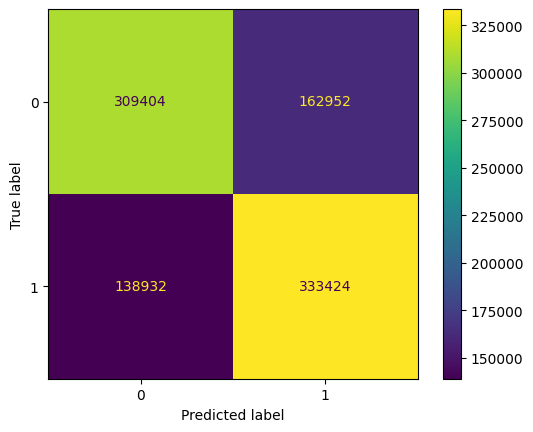

In [86]:
cm = confusion_matrix(y_test, y_pred)
# Create the ConfusionMatrixDisplay object
cmd = ConfusionMatrixDisplay(cm)

# Plot the confusion matrix
cmd.plot()
plt.show()

# Decision Tree 

In [82]:
# defining the model
clf = DecisionTreeClassifier()

# define grid search
paramGrid = {
    #fill more on stronger PCs
    "max_depth": [3, 5],
    "min_samples_split": [2],
    "min_samples_leaf": [1],
    "criterion": ["gini", "entropy"],
}
grid_search_dt = GridSearchCV(estimator=clf, param_grid=paramGrid, cv=3, scoring='accuracy')

# fit the model
grid_search_dt.fit(X_train, y_train)

# After the fitting process, print the best parameters and the best score
print("Best Parameters: ", grid_search_dt.best_params_)

# Use the grid search (with best parameters) to make predictions on the test set

best = grid_search_dt.best_estimator_
y_pred = best.predict(X_test)
print(y_pred)



Best Parameters:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
[1 0 0 ... 1 0 1]


In [83]:
# display metrics
sensitivity, specificity, accuracy, F1_score, Precision, Recall = get_metrics(y_test, y_pred)
dt_df = pd.DataFrame([accuracy, sensitivity, specificity, F1_score, Precision, Recall]).T
dt_df = dt_df.rename(index={0: 'Decision Tree Classifier'}, columns={0: 'Accuracy', 1: 'Sensitivity', 2: 'Specificity' , 3: 'F1_score', 4: 'Precision', 5: 'Recall'})
dt_df

,Accuracy,Sensitivity,Specificity,F1_score,Precision,Recall
Decision Tree Classifier,0.715672,0.739,0.696,0.72894,0.696441,0.76462


In [54]:
row = pd.Series({'Model': 'Decision Tree Classifier', 'Accuracy': accuracy, 'Sensitivity': sensitivity, 'Specificity': specificity, 'F1_score': F1_score, 'Precision': Precision, 'Recall': Recall})
comparison_df.loc[1] = row
del accuracy, sensitivity, specificity, F1_score, Precision, Recall

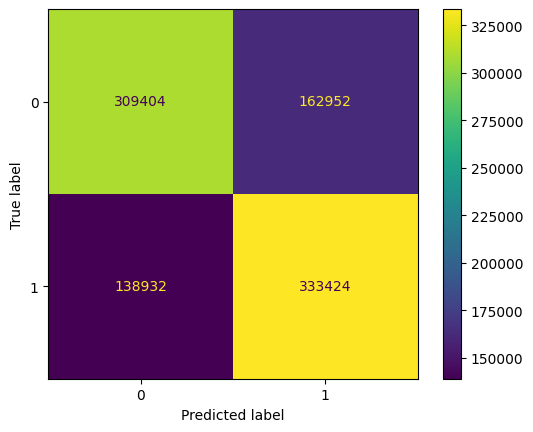

In [87]:
cm = confusion_matrix(y_test, y_pred)
# Create the ConfusionMatrixDisplay object
cmd = ConfusionMatrixDisplay(cm)

# Plot the confusion matrix
cmd.plot()
plt.show()

# XGB


In [88]:
paramGrid = {"max_depth":[5,8], "colsample_bytree":[0.3,0.5]} 

# Define the XGBoost classifier
xgbc = XGBClassifier(objective='binary:logistic', eval_metric='logloss', n_estimators=10)

# Apply GridSearchCV for parameter tuning
gridsearch = GridSearchCV(xgbc, paramGrid, cv=3, verbose=2, n_jobs=1)

In [89]:
model = gridsearch.fit(X_train, y_train)
print("The best parameters are: /n",  gridsearch.best_params_)
model = gridsearch.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ..................colsample_bytree=0.3, max_depth=5; total time=   2.4s
[CV] END ..................colsample_bytree=0.3, max_depth=5; total time=   2.4s
[CV] END ..................colsample_bytree=0.3, max_depth=5; total time=   2.3s
[CV] END ..................colsample_bytree=0.3, max_depth=8; total time=   3.0s
[CV] END ..................colsample_bytree=0.3, max_depth=8; total time=   3.0s
[CV] END ..................colsample_bytree=0.3, max_depth=8; total time=   2.9s
[CV] END ..................colsample_bytree=0.5, max_depth=5; total time=   2.7s
[CV] END ..................colsample_bytree=0.5, max_depth=5; total time=   2.7s
[CV] END ..................colsample_bytree=0.5, max_depth=5; total time=   2.6s
[CV] END ..................colsample_bytree=0.5, max_depth=8; total time=   3.7s
[CV] END ..................colsample_bytree=0.5, max_depth=8; total time=   3.6s
[CV] END ..................colsample_bytree=0.5, 

In [90]:
y_pred = model.predict(X_test)
print(y_pred)

# display metrics
sensitivity, specificity, accuracy, F1_score, Precision, Recall = get_metrics(y_test, y_pred)
gb_df = pd.DataFrame([accuracy, sensitivity, specificity, F1_score, Precision, Recall]).T
gb_df = gb_df.rename(index={0: 'Gradient Boosting Classifier'}, columns={0: 'Accuracy', 1: 'Sensitivity', 2: 'Specificity' , 3: 'F1_score', 4: 'Precision', 5: 'Recall'})
gb_df

[1 1 1 ... 1 1 1]


,Accuracy,Sensitivity,Specificity,F1_score,Precision,Recall
Gradient Boosting Classifier,0.768668,0.802,0.742,0.780663,0.742181,0.823354


In [91]:
row = pd.Series({'Model': 'Gardient Boosting Classifier', 'Accuracy': accuracy, 'Sensitivity': sensitivity, 'Specificity': specificity, 'F1_score': F1_score, 'Precision': Precision, 'Recall': Recall})
comparison_df.loc[2] = row

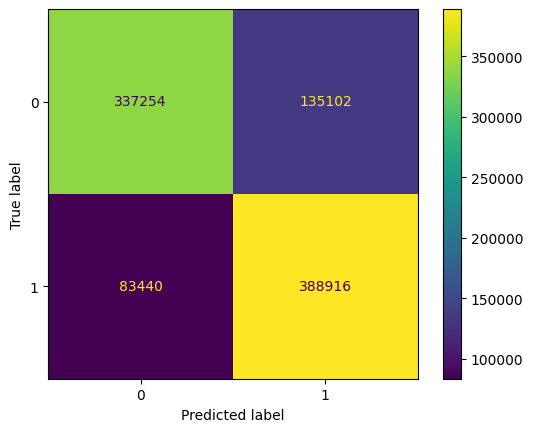

In [92]:
cm = confusion_matrix(y_test, y_pred)
# Create the ConfusionMatrixDisplay object
cmd = ConfusionMatrixDisplay(cm)

# Plot the confusion matrix
cmd.plot()
plt.show()

### Comparing the results of the models

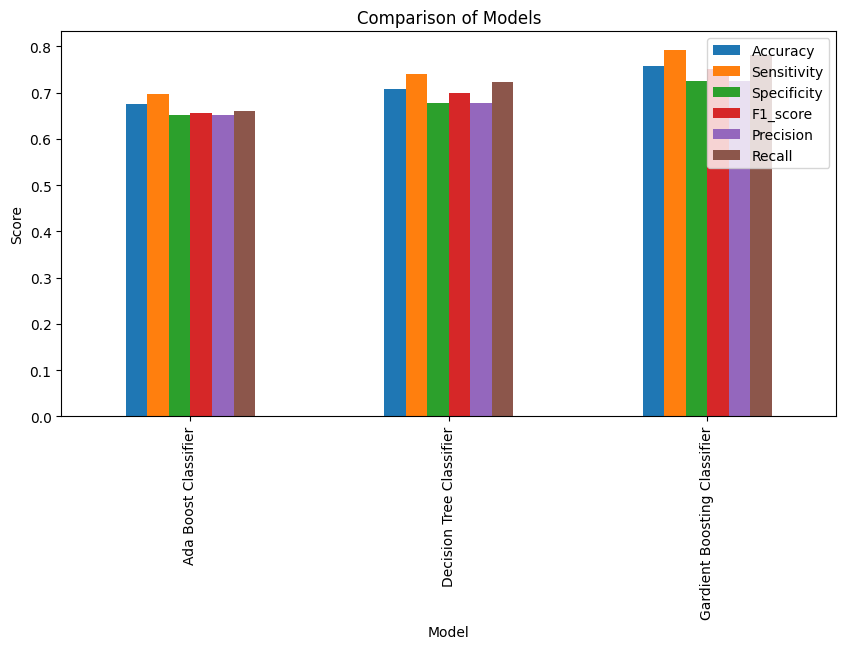

In [61]:
comparison_df.plot(kind='bar', x='Model', y=['Accuracy', 'Sensitivity', 'Specificity', 'F1_score', 'Precision', 'Recall'], figsize=(10,5))
plt.title('Comparison of Models')
plt.ylabel('Score')
plt.show()

# Section D: Clustering

Creating new features that describes customers buying behavior


In [62]:
clus_prior_orders = pd.merge(order_products__prior, orders, on='order_id', how='left')
clus_prior_orders = pd.merge(clus_prior_orders, products, on='product_id', how='left')
clus_prior_orders = clus_prior_orders[['user_id', 'product_id', 'aisle_id', 'department_id', 'order_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]

In [63]:

#calculate favorite day of week for each user
user_dow = clus_prior_orders.groupby(['user_id', 'order_dow']).size().reset_index(name='count')
user_dow = user_dow.sort_values(by=['user_id', 'count'], ascending=False)
user_dow = user_dow.drop_duplicates(subset=['user_id'], keep='first')
user_dow = user_dow[['user_id', 'order_dow']]
user_dow = user_dow.rename(columns={'order_dow': 'favorite_dow'})
clus_prior_orders = pd.merge(clus_prior_orders, user_dow, on='user_id', how='left')

#favourite department for each user
user_department = clus_prior_orders.groupby(['user_id', 'department_id']).size().reset_index(name='count')
user_department = user_department.sort_values(by=['user_id', 'count'], ascending=False)
user_department = user_department.drop_duplicates(subset=['user_id'], keep='first')
user_department = user_department[['user_id', 'department_id']]
user_department = user_department.rename(columns={'department_id': 'favorite_department'})
clus_prior_orders = pd.merge(clus_prior_orders, user_department, on='user_id', how='left')



In [64]:
clus_prior_orders = clus_prior_orders[['user_id', 'favorite_dow','favorite_department']]
clus_prior_orders = clus_prior_orders.drop_duplicates(subset=['user_id'], keep='first')

In [65]:
clus_prior_orders = pd.merge(clus_prior_orders, userData, on='user_id', how='left')

In [66]:
clus_prior_orders

,user_id,favorite_dow,favorite_department,total_orders,avg_basket_size,avg_reorder_ratio,order_hour_of_day_period,average_days_between_orders
0,202279,5,13,8.0,11.250000,0.477778,1,19.322222
1,205970,6,4,25.0,12.920000,0.588235,2,9.337461
2,178520,1,16,56.0,16.482143,0.884074,1,6.631636
3,156122,3,16,52.0,18.596153,0.840745,2,6.834540
4,22352,1,4,8.0,11.375000,0.087912,1,22.857143
...,...,...,...,...,...,...,...,...
206204,106087,6,1,3.0,8.333333,0.120000,2,1.800000
206205,9295,6,16,3.0,3.333333,0.400000,3,20.400000
206206,106586,5,13,3.0,5.000000,0.066667,1,15.533334
206207,181902,0,4,3.0,20.333334,0.262295,3,3.901639


In [67]:
clus_prior_orders = clus_prior_orders.drop(columns=['user_id'])

    Might add more features

In [68]:
#import Kmeans and cdists
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def elbow_met(df):

    # k means determine k
    distortions = []
    K = range(1,10)
    for k in K:
        kmeanModel = KMeans(n_clusters=k,n_init=10).fit(clus_prior_orders)
        kmeanModel.fit(clus_prior_orders)
        distortions.append(sum(np.min(cdist(clus_prior_orders, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / clus_prior_orders.shape[0])

    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Within groups sum of squares')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [69]:
clus_prior_orders

,favorite_dow,favorite_department,total_orders,avg_basket_size,avg_reorder_ratio,order_hour_of_day_period,average_days_between_orders
0,5,13,8.0,11.250000,0.477778,1,19.322222
1,6,4,25.0,12.920000,0.588235,2,9.337461
2,1,16,56.0,16.482143,0.884074,1,6.631636
3,3,16,52.0,18.596153,0.840745,2,6.834540
4,1,4,8.0,11.375000,0.087912,1,22.857143
...,...,...,...,...,...,...,...
206204,6,1,3.0,8.333333,0.120000,2,1.800000
206205,6,16,3.0,3.333333,0.400000,3,20.400000
206206,5,13,3.0,5.000000,0.066667,1,15.533334
206207,0,4,3.0,20.333334,0.262295,3,3.901639


In [70]:
elbow_met(clus_prior_orders)

ValueError: Unsupported dtype object

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0,n_init=10).fit(clus_prior_orders)


In [ ]:
centroids = kmeans.cluster_centers_
print(centroids)

[[5.16770000e+04 2.52050739e+00 7.34059969e+00]
 [1.54781500e+05 2.52199191e+00 7.37228747e+00]]


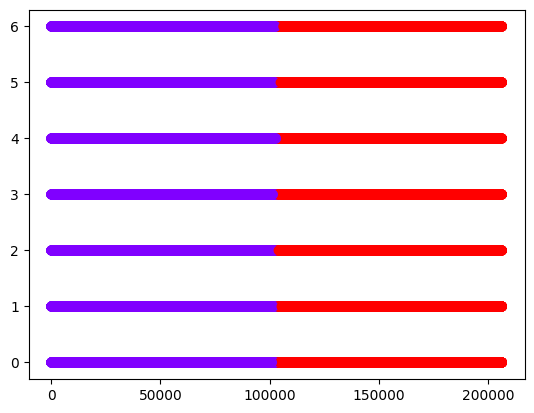

In [ ]:
#run kmeans with 2 and plot
kmeans = KMeans(n_clusters=2, random_state=0,n_init=10).fit(clus_prior_orders)
plt.scatter(clus_prior_orders.iloc[:,0], clus_prior_orders.iloc[:,1], c=kmeans.labels_, cmap='rainbow')


# BONUS

## PCA - 2 features

In [ ]:
#apply pca for User data
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(cluster_prior)
principalDf = pd.DataFrame(data = principalComponents
                           
                , columns = ['principal component 1', 'principal component 2'])

principalDf

NameError: name 'cluster_prior' is not defined

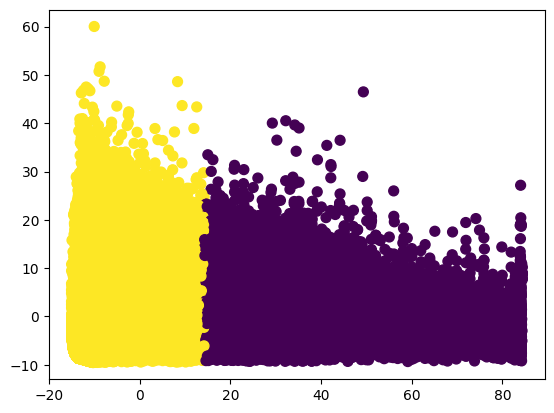

In [ ]:
#plot PCA
plt.scatter(principalDf.iloc[:, 0], principalDf.iloc[:, 1], c=labels, s=50, cmap='viridis')
